### Importando as bibliotecas e definindo algumas classes/funções que serão utilizadas

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def MyNullTreatment(dataframe):
    actions_to_perform = {}
    
    # column of numbers 
    actions_to_perform['Zero']=['MSZoning','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','2ndFlrSF','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
    actions_to_perform['Mean']=['LotFrontage','LotArea','GrLivArea','GarageArea']
    actions_to_perform['Mode']=['OverallQual','OverallCond','YearBuilt','YearRemodAdd','1stFlrSF','BsmtFullBath','BsmtHalfBath','FullBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','MoSold','YrSold']
    
    # column of words
    actions_to_perform['Mode'] += ['Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','RoofStyle','RoofMatl','ExterQual','ExterCond','Foundation','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','PavedDrive']
    actions_to_perform['None']=['Neighborhood','BldgType','HouseStyle','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','Alley']
    actions_to_perform['Other']=['Exterior1st','Exterior2nd']
    actions_to_perform['Oth']=['SaleType']
    actions_to_perform['Norm']=['Condition1','Condition2']
    
    for act in actions_to_perform:
        if act == 'Zero':
            for col in actions_to_perform['Zero']:
                dataframe[col]=dataframe[col].fillna(0)
        if act == 'Mean':
            for col in actions_to_perform['Mean']:
                dataframe[col]=dataframe[col].fillna(dataframe[col].mean())
        if act == 'Mode':
            for col in actions_to_perform['Mode']:
                dataframe[col]=dataframe[col].fillna(dataframe[col].mode()[0])
        if act in ['None','Other','Oth','Norm']:
            for col in actions_to_perform[act]:
                dataframe[col]=dataframe[col].fillna(col)
                
    return dataframe

    
class MyOneHotEncoder:
    def __init__(self, column_list):
        self.ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown = 'ignore'), column_list)], remainder='passthrough')
        
    def fit_and_transform(self,dataframe):
        return self.ct.fit_transform(dataframe)
    
    def transform(self,dataframe):
        return self.ct.transform(dataframe)

class MyMinMaxScaler:
    def __init__(self, scaler_list):
        self.scaler_list = scaler_list
        self.column={}
        
    def fit_and_transform(self,dataframe):
        try:
            for col in self.scaler_list:
                self.column[col] = MinMaxScaler((0,1))
                dataframe[col] = pd.DataFrame(self.column[col].fit_transform((dataframe[col].to_numpy()).reshape(-1,1)))[0] 
            return dataframe
        except Exception as e:
            print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
    
    def transform(self,dataframe):
        try:
            for col in self.scaler_list:
                if (col != 'SalePrice') | ('SalePrice' in dataframe.columns):
                    dataframe[col] = pd.DataFrame(self.column[col].transform((dataframe[col].to_numpy()).reshape(-1,1)))[0]
            return dataframe
        except Exception as e:
            print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
    
    def inverse_transform(self, dataframe, column_name):
        if type(dataframe) == np.ndarray:
            return self.column[column_name].inverse_transform(dataframe.reshape((-1,1)))
        elif type(dataframe) == pd.core.series.Series:
            return self.column[column_name].inverse_transform(dataframe.values.reshape(-1,1))
        else:
            return self.column[column_name].inverse_transform(dataframe)
        
    
class MyStdScaler:
    def __init__(self, scaler_list):
        self.scaler_list = scaler_list
        self.column={}
        
    def fit_and_transform(self,dataframe):
        try:
            for col in self.scaler_list:
                self.column[col] = StandardScaler()
                dataframe[col] = pd.DataFrame(self.column[col].fit_transform((dataframe[col].to_numpy()).reshape(-1,1)))[0] 
            return dataframe
        except Exception as e:
            print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
    
    def transform(self,dataframe):
        try:
            for col in self.scaler_list:
                if (col != 'SalePrice') | ('SalePrice' in dataframe.columns):
                    dataframe[col] = pd.DataFrame(self.column[col].transform((dataframe[col].to_numpy()).reshape(-1,1)))[0]
            return dataframe
        except Exception as e:
            print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
    
    def inverse_transform(self, dataframe, column_name):
        if type(dataframe) == np.ndarray:
            return self.column[column_name].inverse_transform(dataframe.reshape((-1,1)))
        elif type(dataframe) == pd.core.series.Series:
            return self.column[column_name].inverse_transform(dataframe.values.reshape(-1,1))
        else:
            return self.column[column_name].inverse_transform(dataframe)
    
    
def Calculate_Predictions(trained_models):
    results = {}
    for model_name in trained_models:
        results[model_name] = {}

        y_pred = trained_models[model_name].predict(x_test)
        #y_pred = myMinMaxScaler.inverse_transform(y_pred,'SalePrice')
        y_pred = myStdScaler.inverse_transform(y_pred,'SalePrice')
        results[model_name]['y_pred'] = y_pred

        compare = pd.DataFrame(np.concatenate([y_test.reshape(-1,1), y_pred.reshape(-1,1)],axis=1), columns=['y_test','y_pred'])
        compare['dif'] = compare['y_pred']/compare['y_test']
        #log_pred = compare['y_pred'].apply(lambda x: math.log(x))
        #log_test = compare['y_test'].apply(lambda x: math.log(x))
        #compare['score'] = mean_squared_error(log_pred,log_test, squared=False)
        results[model_name]['compare'] = compare
        print('{}\n{}\n\n'.format(model_name,compare.describe().loc[['mean','std']]))
    
    return results

### Aqui importamos a nossa base de treino, já eliminamos algumas colunas baseado em uma análise manual prévia junto ao entendimento de cada coluna. Em seguida visualizamos como está a dispersão dos valores nulos.

<AxesSubplot:>

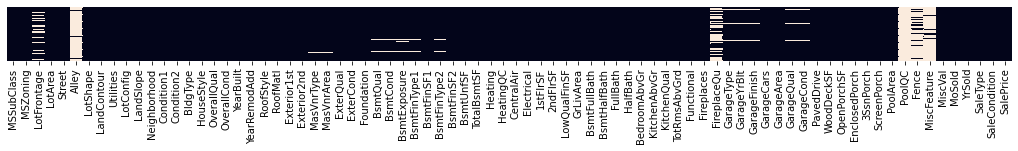

In [2]:
mydata_df = pd.read_csv('train.csv').drop(columns=['Id'])
fig, ax = plt.subplots(figsize=(18,1))
sns.heatmap(mydata_df.isnull(),ax=ax,yticklabels=False, cbar=False)

### Aqui fazemos o tratamento dos dados e a separação do conjunto de treino(80%) e teste(20%)

In [3]:
mydata_df = MyNullTreatment(mydata_df)

stdscaler_list = ['GrLivArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
minmaxscaler_list = ['LotFrontage','LotArea','GarageArea','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold','SalePrice']

onehot_list = ['MSSubClass']

for col in mydata_df.columns:
    if (mydata_df[col].dtype not in ('int64','float64')) :
        onehot_list.append(col)

try:
    myStdScaler =  MyStdScaler(stdscaler_list+minmaxscaler_list)
    mydata_df = myStdScaler.fit_and_transform(mydata_df)
    
    #myMinMaxScaler =  MyMinMaxScaler(minmaxscaler_list)
    #mydata_df = myMinMaxScaler.fit_and_transform(mydata_df)
    
    x,y = mydata_df.iloc[:,:-1], mydata_df.iloc[:,-1]
    
    myOneHotEncoder = MyOneHotEncoder(onehot_list)
    x = myOneHotEncoder.fit_and_transform(x)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
    #y_test = myMinMaxScaler.inverse_transform(y_test,'SalePrice')
    y_test = myStdScaler.inverse_transform(y_test,'SalePrice')
except Exception as e:
    print(e)

### Em seguida criamos um dicionário dos modelos treinados e chamamos uma função para realizar as predições e mostrar os resultados de maneira resumida

In [4]:
trained_models = {}

trained_models['MultipleLinear'] = LinearRegression()
trained_models['MultipleLinear'].fit(x_train, y_train)

trained_models['SVR'] = SVR(kernel = 'rbf')
trained_models['SVR'].fit(x_train, y_train)

trained_models['DecisionTree'] = DecisionTreeRegressor(random_state = 0)
trained_models['DecisionTree'].fit(x_train,y_train)

trained_models['RandomForest'] = RandomForestRegressor(n_estimators = 271, random_state = 0)
trained_models['RandomForest'].fit(x_train,y_train)

trained_models['XGBoost'] = xgboost.XGBRegressor()
trained_models['XGBoost'].fit(x_train,y_train)

trained_models['MLPRegressor'] = MLPRegressor()
trained_models['MLPRegressor'].fit(x_train,y_train)

prediction_results = Calculate_Predictions(trained_models)
   

MultipleLinear
             y_test         y_pred       dif
mean  181370.383562  181804.306844  1.014374
std    83244.107342   89791.729810  0.341656


SVR
             y_test         y_pred       dif
mean  181370.383562  178406.632492  1.003551
std    83244.107342   69716.072783  0.136876


DecisionTree
             y_test         y_pred       dif
mean  181370.383562  182262.092466  1.019159
std    83244.107342   84025.773432  0.224861


RandomForest
             y_test         y_pred       dif
mean  181370.383562  181591.365314  1.023185
std    83244.107342   73871.372293  0.178230


XGBoost
             y_test         y_pred       dif
mean  181370.383562  182704.238897  1.022118
std    83244.107342   77306.966329  0.168740


MLPRegressor
             y_test         y_pred       dif
mean  181370.383562  182165.187066  1.020018
std    83244.107342   81094.784139  0.247601




#### A coluna 'dif' dos modelos acima, é uma divisão entre o y_test/y_pred ... ou seja, quanto mais a média(mean) for próxima de 1, mais acertivo foi o nosso modelo ... e quanto menor o valor do desvio padrão(std), menor é a dispersão dos dados quanto ao valor previsto.
#### Levando isso em conta temos então que os 2 melhores modelos são o SVR e o XGBoost, onde este segundo vence apenas por uma menor dispersão enquanto o primeiro por uma melhor acertividade.

#### Para conferir e explorar os valores previstos com cada modelo, basta utilizar o dicionário 'prediction_results'.
#### Este dicionario contém 'y_pred' de cada modelo e uma tabela comparativa
Ex.: prediction_results['SVR']['compare']

#### Segue abaixo uma tabela com os valores previstos de cada modelo

In [5]:
model_results = pd.concat([ pd.DataFrame(prediction_results[model_name]['y_pred'], columns=[model_name]) for model_name in prediction_results], axis=1)
model_results = pd.concat([pd.DataFrame(y_test, columns=['Y_Test']),model_results],axis=1)
model_results

,Y_Test,MultipleLinear,SVR,DecisionTree,RandomForest,XGBoost,MLPRegressor
0,200624.0,267327.402469,260882.748367,235000.0,209833.642066,244366.203125,302694.130338
1,133000.0,145749.022855,158834.411458,117500.0,148609.177122,147418.140625,158691.449799
2,110000.0,110274.089375,116812.223408,119500.0,106054.479705,105712.703125,93399.202394
3,192000.0,211933.240154,213740.388499,226000.0,221517.811808,211382.046875,211735.255026
4,88000.0,91531.532783,97505.045471,94500.0,92881.523985,89862.898438,103658.024080
...,...,...,...,...,...,...,...
287,324000.0,304269.291701,281487.906885,274900.0,295997.498155,309407.187500,311068.409368
288,555000.0,476345.704815,414176.934388,465000.0,452167.845018,510274.031250,491924.828319
289,136000.0,256750.766235,171062.098782,128000.0,157702.752768,174081.906250,188475.774505
290,82500.0,107494.606204,90408.924396,75500.0,82720.678967,83101.000000,80579.838105


#### Adotaremos o SVR como o melhor modelo e criaremos o arquivo "sample_submission.csv" para enviar ao Kaagle

In [7]:
submission_data = pd.read_csv('test.csv')
subdata_df = submission_data.copy()
subdata_df = subdata_df.drop(columns=['Id'])
subdata_df = MyNullTreatment(subdata_df)

try:
    #subdata_df = myLabelEncoder.transform(subdata_df)
    subdata_df = myStdScaler.transform(subdata_df)
    subdata_df = myOneHotEncoder.transform(subdata_df) 
except Exception as e:
    print(e)

y_subm = trained_models['SVR'].predict(subdata_df)
y_subm = myStdScaler.inverse_transform(y_subm,'SalePrice')
sample_submission = pd.DataFrame(y_subm, columns=['SalePrice'], index=submission_data['Id'].array)
sample_submission.to_csv('sample_submission.csv',index_label='Id')
